In [4]:
!pip install causalnex

In [5]:
!pip install dowhy

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy

#warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [10]:
df = pd.read_csv('/content/gdrive/MyDrive/Causal-Inference/data/data.csv')

In [11]:
causal_df = df.drop(['id', 'Unnamed: 32'], axis=1).copy()

In [12]:
d = {'B':0, 'M':1}
causal_df['diagnosis'] = causal_df['diagnosis'].map(d)

In [13]:
causal_df['low_radius'] = causal_df['radius_mean'].apply(lambda x: True if x < 18 else False)

In [14]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(causal_df, random_state=20, test_size=.2)

In [15]:
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.structure.notears import from_pandas_lasso
sm = from_pandas(train_df.iloc[:, :12], tabu_parent_nodes=['diagnosis'],)

In [16]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Image
def vis_sm(sm):
  viz = plot_structure(
      sm,
      graph_attributes={"scale": "2.0", 'size': 3.0},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

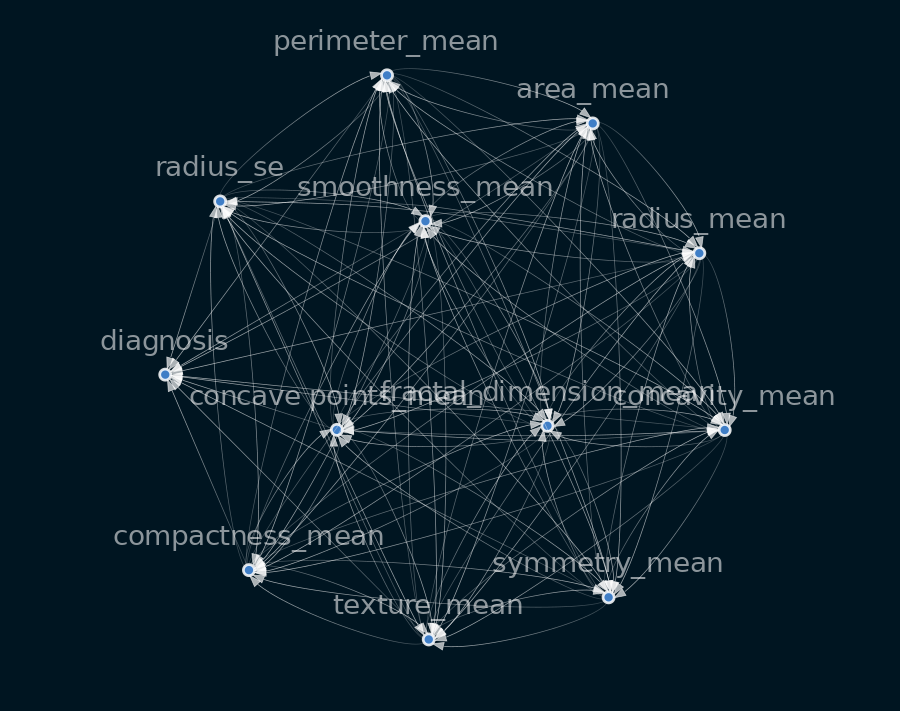

In [17]:
vis_sm(sm)

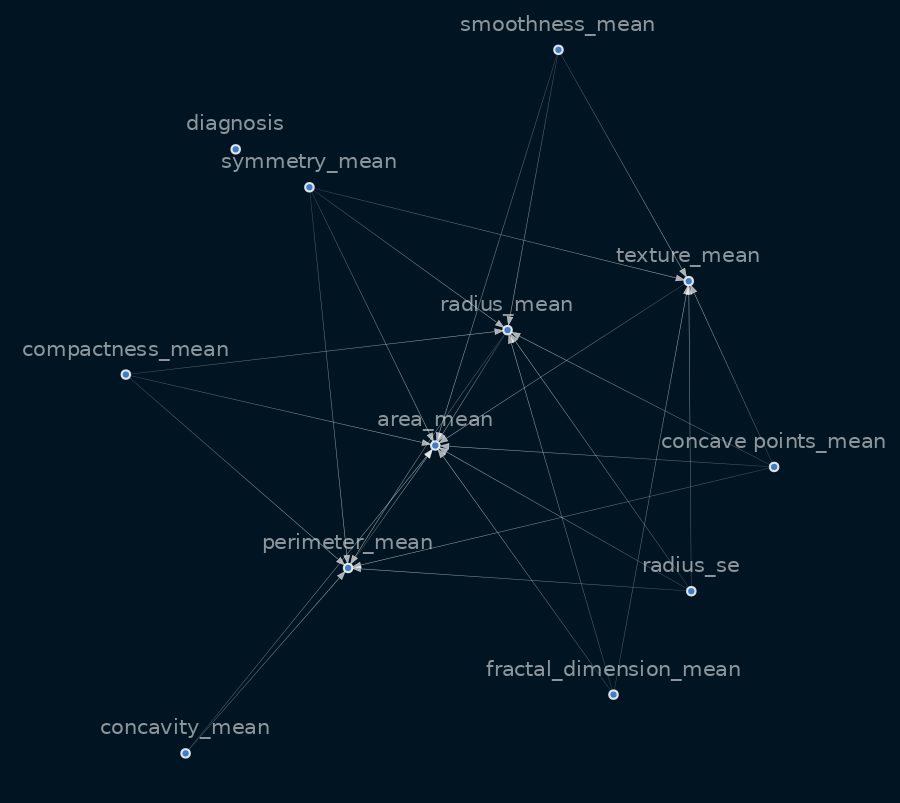

In [18]:
sm.remove_edges_below_threshold(0.9)
vis_sm(sm)

In [19]:
# 50%
causal_selected = train_df.iloc[:, :10]
portion = int(causal_selected.shape[0] *.5)
x_portion = causal_selected.head(portion)

In [ ]:
%%time
sm1 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm1 = sm1.get_largest_subgraph()
vis_sm(sm1)

In [ ]:
vis_sm(sm1)

In [ ]:
portion = int(causal_selected.shape[0] *.6)
x_portion = causal_selected.head(portion)

In [ ]:
%%time
sm2 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm2 = sm2.get_largest_subgraph()

In [ ]:
vis_sm(sm2)

In [ ]:
portion = int(causal_selected.shape[0] *.7)
x_portion = causal_selected.head(portion)

In [ ]:
%%time
sm3 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm3 = sm3.get_largest_subgraph()

In [ ]:
vis_sm(sm3)

In [ ]:
portion = int(causal_selected.shape[0] *.8)
x_portion = causal_selected.head(portion)

In [ ]:
%%time
sm4 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm4 = sm4.get_largest_subgraph()

In [ ]:
vis_sm(sm4)

In [ ]:
portion = int(causal_selected.shape[0] *.9)
x_portion = causal_selected.head(portion)

In [ ]:
%%time
sm5 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm5 = sm5.get_largest_subgraph()

In [ ]:
vis_sm(sm5)

In [ ]:
a_sm = np.array(sm1.edges)
b_sm = np.array(sm2.edges)

In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(a_sm, b_sm, average='samples')

In [36]:
# final graph
%%time
new_sm = from_pandas_lasso( causal_selected,
                        tabu_parent_nodes=['diagnosis'], 
                        w_threshold=0.3, 
                        beta=0.8)

CPU times: user 1min 1s, sys: 1min 14s, total: 2min 15s
Wall time: 1min 9s


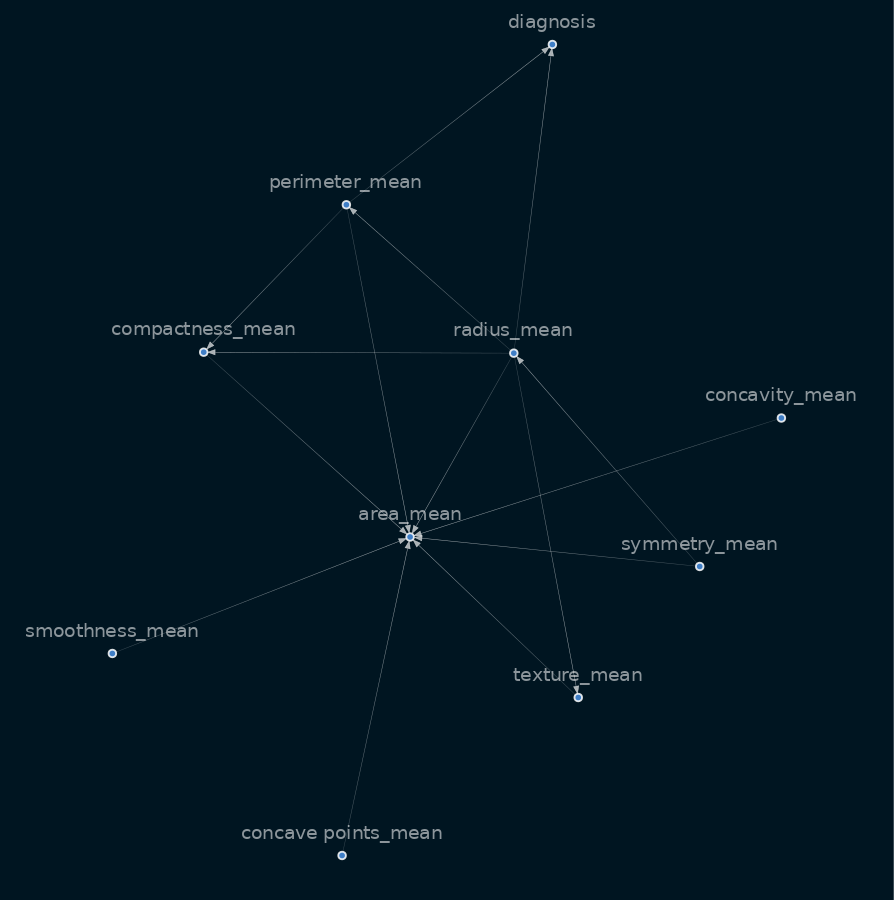

In [37]:
vis_sm(new_sm)

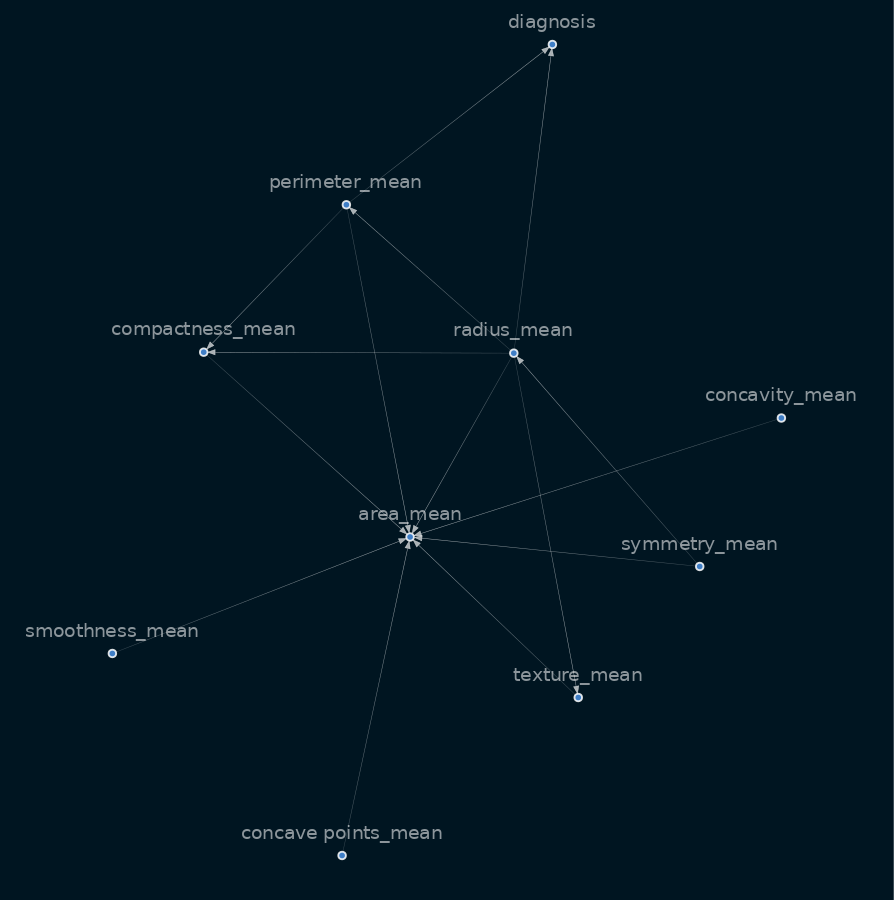

In [38]:
new_sm = new_sm.get_largest_subgraph()
vis_sm(new_sm)

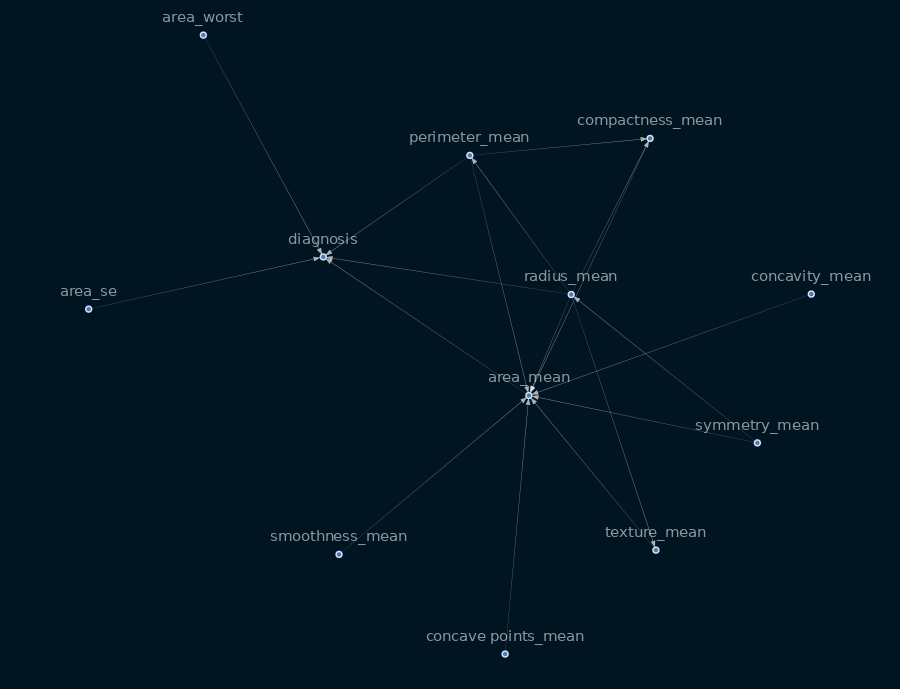

In [39]:
new_sm.add_edge("area_mean", "diagnosis")
new_sm.add_edge("area_se", "diagnosis")
new_sm.add_edge("area_worst", "diagnosis")
vis_sm(new_sm)

In [44]:
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket


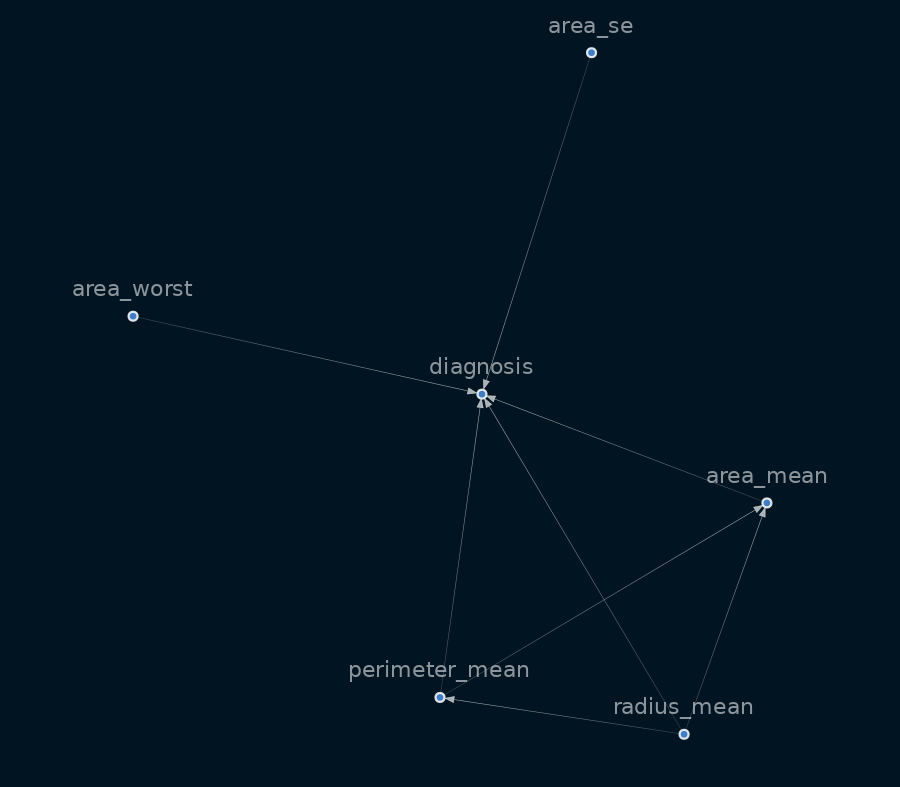

In [45]:
from causalnex.utils.network_utils import get_markov_blanket
bn = BayesianNetwork(new_sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)
edge_list
vis_sm(blanket.structure)

## Modelling

Modelling will be done in two parts: one will be created using all the given features from the data and anothe will be created using just the feautres that have been identified in the stable graph.

In [46]:
train_df1 = train_df.copy()
valid_df1 = valid_df.copy()

# Select the target column
y_train = train_df1.diagnosis
y_test = valid_df1.diagnosis

# Select the features
X_train = train_df1.drop(['diagnosis', 'low_radius'], axis=1)
X_test = valid_df1.drop(['diagnosis', 'low_radius'], axis=1)

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [48]:
def scaler(be_scaled):
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  scaled = scaler.fit_transform(be_scaled)
  return scaled

In [49]:
x_train = scaler(X_train)
x_test = scaler(X_test)

In [50]:
class Models():
  def __init__(self, x_train, y_train, x_test, y_test):
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test

  def log_reg(self):
    #Using Logistic Regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state = 0)
    log.fit(x_train, y_train)
    #print model accuracy on the training data.
    print('[0]Logistic Regression Training Accuracy:', log.score(x_train, y_train))
    print('[1]Logistic Regression Testing Accuracy:', log.score(x_test, y_test))

  def svc_linear(self):
    #Using SVC linear
    from sklearn.svm import SVC
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(x_train, y_train)
    #print model accuracy on the training data
    print('[0]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(x_train, y_train))
    print('[1]Support Vector Machine (Linear Classifier) Testing Accuracy:', svc_lin.score(x_test, y_test))

  def svc_rbf(self):
    #Using SVC rbf
    from sklearn.svm import SVC
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(x_train, y_train)
    #print model accuracy on the training data
    print('[0]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(x_train, y_train))
    print('[1]Support Vector Machine (RBF Classifier) Testing Accuracy:', svc_rbf.score(x_test, y_test))

  def decision_tree(self):
    #Using DecisionTreeClassifier 
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(x_train, y_train)
    #print model accuracy on the training data
    print('[0]Decision Tree Classifier Training Accuracy:', tree.score(x_train, y_train))
    print('[1]Decision Tree Classifier Testing Accuracy:', tree.score(x_test, y_test))

  def random_forest(self):
    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(x_train, y_train)
    #print model accuracy on the training data 
    print('[0]Random Forest Classifier Training Accuracy:', forest.score(x_train, y_train))
    print('[1]Random Forest Classifier Testing Accuracy:', forest.score(x_test, y_test))

In [51]:
models = Models(x_train, y_train, x_test, y_test)

In [52]:
models.log_reg()

[0]Logistic Regression Training Accuracy: 0.9868131868131869
[1]Logistic Regression Testing Accuracy: 0.9824561403508771


In [53]:
models.decision_tree()

[0]Decision Tree Classifier Training Accuracy: 1.0
[1]Decision Tree Classifier Testing Accuracy: 0.956140350877193


In [54]:
models.random_forest()

[0]Random Forest Classifier Training Accuracy: 1.0
[1]Random Forest Classifier Testing Accuracy: 0.9736842105263158


## Selecting features identified by the graph

In [55]:
train_features = {'diagnosis','radius_mean','area_mean','area_worst','area_se'}
train_columns = [col for col in train_df 
                      if any(feature in col for feature in train_features)]
train_columns

['diagnosis', 'radius_mean', 'area_mean', 'area_se', 'area_worst']

In [56]:
training = train_df[train_columns]
valid = valid_df[train_columns]

In [57]:
y_train = training.diagnosis
X_training = training.drop('diagnosis', axis=1)
y_test = valid.diagnosis
X_testing = valid.drop('diagnosis', axis=1)

In [58]:
x_test = scaler(X_testing)
x_train = scaler(X_training)

In [62]:
model2 = Models(X_training, y_train, X_testing, y_test)

In [63]:
model2.log_reg()

[0]Logistic Regression Training Accuracy: 0.9186813186813186
[1]Logistic Regression Testing Accuracy: 0.9210526315789473


In [64]:
model2.random_forest()

[0]Random Forest Classifier Training Accuracy: 0.9934065934065934
[1]Random Forest Classifier Testing Accuracy: 0.9298245614035088
